In [1]:
import os 
import pandas as pd
# xls dosyaları için
from bs4 import BeautifulSoup
# resimleri arraya dönüştürmek için
import cv2
from numpy import asarray
import numpy as np

# Matplotlib ile resimler okunacak
from matplotlib import image
from matplotlib import pyplot as plt
import imutils

import shutil

from keras.preprocessing.image import ImageDataGenerator
import glob

Using TensorFlow backend.
C:\Users\cemnu\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cemnu\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cemnu\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cemnu\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
malign_label = []
img_set = []


for i in range(1,401):
    try :
    
        with open("""thyroid/"""+str(i)+""".xml""", 'r') as f:
            if f:
                data = f.read()
    except:
        pass
    bs_read = BeautifulSoup(data, "xml")
    

# bu kısımdaki bütün işlemler görselleri ayıklamak için yapıldı
# içeriğinde tirad değeri olmayan dosyalar dikkate alınmadı
# 
    number = bs_read.find('number').text
    
    tirads = bs_read.find('tirads').text
    if tirads:
        if tirads ==( "2" or "3"):
            malign=0
        else:
            malign=1
    
        image_no = bs_read.find_all('image')
        for x in image_no:
            a =x.text
            
            jpg_title="""thyroid/"""+str(number)+"""_"""+str(a)+""".jpg"""
            
            img = cv2.imread(jpg_title)
            
           
            

            
            img_set.append(img)
            malign_label.append(malign) 
        
            
             
    
    else : 
        pass
        
        





Bu kısımda fotoğrafları kesmek istediğim için çözüm ararken alttaki kod parçaçığını buldum.
Fotoğrafların sınırlarını tespit ederek kesme işlemi uygulayan bir kod parçacığı hazır kod olduğu için yorumlara ellemedim.

In [3]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [4]:
X_crop= crop_imgs(img_set)


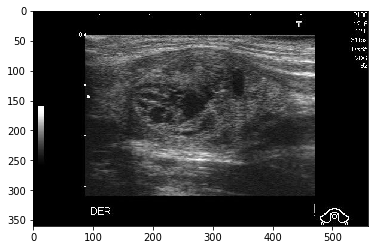

In [5]:
#örnek
plt.imshow(img_set[2])

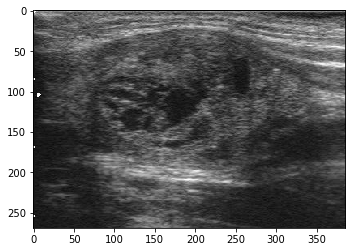

In [6]:
#örnek
plt.imshow(X_crop[2])

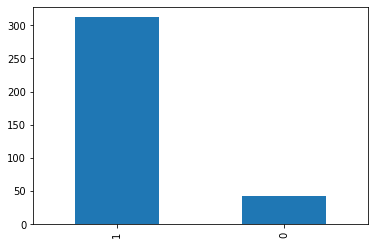

In [7]:
#Değerlerin dağılımını gözlemleyebilmek için görselleştirme yapıldı 
images = np.array(X_crop)
label = np.array(malign_label)
df=pd.DataFrame({'malign': malign_label, 'img': list(X_crop)},columns=["img","malign"])
df.malign.value_counts().plot(kind='bar')

In [8]:
#Dengeleme işlemi  
df1=df[df['malign']==0]
print("benigns -df1:"+ str(df1.shape))
df2=df[df['malign']==1]
print("maligns -df2:"+ str(df2.shape))
Data=df1.append(df2[:len(df1)])
print("balanced data:"+str(Data.shape))


benigns -df1:(43, 2)
maligns -df2:(312, 2)
balanced data:(86, 2)


In [9]:

from sklearn.model_selection import train_test_split
X=Data.img
Y=Data.malign
print(len(X))
# İlk olarak sonradan manuel deneme yapabilmek için bir kısım fotoğraf ayırdım
X_1,X_val,y_1,y_val = train_test_split(X,Y,test_size=0.20)

86


In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_1,y_1,test_size=0.33)

In [11]:
# Fotoğrafları istenilen boyuta ayarlandı 
def resize_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,

        )
        set_new.append(img)
    return np.array(set_new)

In [12]:
IMG_SIZE=(224,224)
X_train_prep = resize_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = resize_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = resize_imgs(set_name=X_val, img_size=IMG_SIZE)


In [13]:
# Data generatör flow from directory fonksiyonu için klasörlere kaydedildi 
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, malign) in zip(x_set, y_set):
        if malign == "0":
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
    
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1
        


In [14]:
save_new_images(X_train_prep, y_train, folder_name='TRAIN_CROP_MALIGN/')
save_new_images(X_test_prep, y_test,folder_name='TEST_CROP_MALIGN/')


In [15]:
# klasör yolu 
TRAIN_DIR="TRAIN_CROP_MALIGN/"
TEST_DIR="TEST_CROP_MALIGN/"

In [16]:
# Fotoğraf verisini arttırmak için image data  generatör kullandık 
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
)

In [17]:
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary'
)


Found 114 images belonging to 2 classes.


In [18]:
test_generator = datagen.flow_from_directory(
    TEST_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary'
)


Found 50 images belonging to 2 classes.


In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.optimizers import Adam, RMSprop
from keras.applications.vgg16 import VGG16


In [20]:
# Model olarak Vgg16 modeli kullanıldı 
base_model = VGG16(
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [21]:
model = VGG16()
model = Sequential()


model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 25,692,161
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
print(X_train_prep.shape)
y_train=np.array(y_train)

y_test=np.array(y_test)

print(y_train.shape)
print(y_test.shape)
print(X_test_prep.shape)

(45, 224, 224, 3)
(45,)
(23,)
(23, 224, 224, 3)


In [24]:
history =model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data=test_generator,
        validation_steps=20  )


Epoch 1/20
100/100 [==============================] - 230s 2s/step - loss: 7.9281 - acc: 0.5789 - val_loss: 0.7511 - val_acc: 0.5811
Epoch 2/20
100/100 [==============================] - 249s 2s/step - loss: 0.6396 - acc: 0.6171 - val_loss: 0.7241 - val_acc: 0.6479
Epoch 3/20
100/100 [==============================] - 234s 2s/step - loss: 0.6225 - acc: 0.6946 - val_loss: 0.5341 - val_acc: 0.5704
Epoch 4/20
100/100 [==============================] - 234s 2s/step - loss: 0.5566 - acc: 0.7039 - val_loss: 0.3577 - val_acc: 0.6479
Epoch 5/20
100/100 [==============================] - 235s 2s/step - loss: 0.5501 - acc: 0.7355 - val_loss: 0.5127 - val_acc: 0.5845
Epoch 6/20
100/100 [==============================] - 231s 2s/step - loss: 0.5316 - acc: 0.7291 - val_loss: 0.4479 - val_acc: 0.6056
Epoch 7/20
100/100 [==============================] - 235s 2s/step - loss: 0.4924 - acc: 0.7736 - val_loss: 0.7520 - val_acc: 0.6338
Epoch 8/20
100/100 [==============================] - 241s 2s/step -

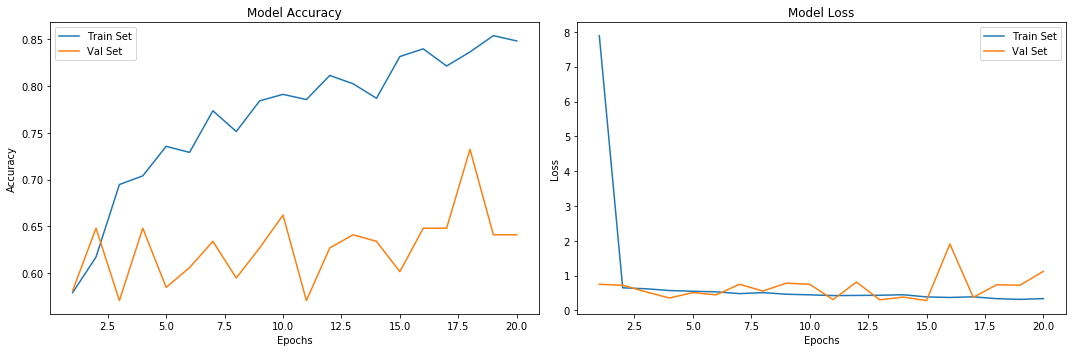

In [27]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.56
[[1 6]
 [2 9]]


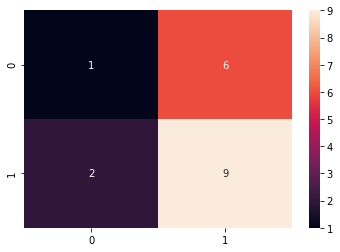

In [34]:


predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]


from sklearn.metrics import accuracy_score, confusion_matrix,plot_confusion_matrix
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)



cm = confusion_matrix(y_val, predictions)
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)